# 2020 Fantasy Baseball Player Rankings

Created by Jacob Richey

Rankings designed for a snake draft in an ESPN H2H Categories league, with a standard scoring system.

Projections from nine systems - ATC, ESPN, FanGraphs Depth Charts, NumberFire, Razzball, Steamer, THE BAT, THE BAT X, and ZiPS - are combined to produce a consensus player ranking, with potential boom/bust notes added based on the sample skewness of player projections.

## Import modules

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore, skew

## Read in hitter projections

[Steamer Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=steamer&team=0&lg=all&players=0) -> 'Export Data'  
[Steamer Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=steamer&team=0&lg=all&players=0) -> 'Export Data'

[people.csv (Chadwick Register)](https://github.com/chadwickbureau/register) -> 'data' -> 'people.csv' -> 'Download'

In [4]:
names = pd.concat([
    pd.read_csv("fb2020_data/steamer_batters_2020.csv").set_index('playerid').loc[:, 'Name'],
    pd.read_csv("fb2020_data/steamer_pitchers_2020.csv").set_index('playerid').loc[:, 'Name']])

# create conversion df with player name, fangraphs id, and mlbam id
# will use fangraphs id as index throughout
register = (pd.read_csv("fb2020_data/people.csv", dtype = 'str')
            .loc[:, ['key_mlbam', 'key_fangraphs']]
            .merge(names, how = 'right', left_on = 'key_fangraphs', right_on = 'playerid')
            .dropna()
            .query("key_fangraphs != '10171'")) # double Jose Ramirez entries, remove incorrect key

[ESPN Projections](https://fantasy.espn.com/baseball/players/projections) -> sortable projections -> copy and paste top 300 players into csv file -> clean further in Python

In [5]:
espn_batters = pd.read_csv("fb2020_data/espn_batters_2020.csv")

# cells of importance (Name, Position) located every third row over the Rank and Player columns
rank = espn_batters['RANK'].iloc[::3]
espn_names = (espn_batters['PLAYER'].iloc[1::3]
              .replace(['Pete Alonso', 'Gio Urshela', 'Nate Lowe'],
                       ['Peter Alonso', 'Giovanny Urshela', 'Nathaniel Lowe'])
              .str.replace('DTD|IL10|IL60', '', regex = True))
positions = espn_batters['PLAYER'].iloc[2::3].str.replace(
    ("Ari|Atl|Bal|Bos|ChC|CHW|Cin|Cle|Col|Det|FA|Hou|KC|"
     "LAA||LAD|Mia|Mil|Min|NYM|NYY|Oak|Phi|Pit|SD|Sea|SF|"
     "StL|TB|Tex||Tor|Wsh|ChW"), '', regex = True)
hab = espn_batters['H/AB'].iloc[0:300].str.split("/", expand = True)

# combine isolated Rank, Name, and Position with player stats
espn_batters = (pd.DataFrame({
    'ESPN_Rank': rank.reset_index(drop = True),
    'Name': espn_names.reset_index(drop = True),
    'Position': positions.reset_index(drop = True),
    'AB': hab[1],
    'H': hab[0],
    'R': espn_batters['R'].iloc[0:300],
    'HR': espn_batters['HR'].iloc[0:300],
    'RBI': espn_batters['RBI'].iloc[0:300],
    'SB': espn_batters['SB'].iloc[0:300],
    'AVG': espn_batters['AVG'].iloc[0:300]})
                .merge(register[['key_fangraphs', 'Name']], on = 'Name') # add fangraphs id, set as index
                .assign(System = "ESPN")
                .rename(columns = {'key_fangraphs': 'playerid'})
                .set_index('playerid')
                .query("R != '--'") # remove row of TBD projections for Yasiel Puig (unsigned free agent)
                .drop_duplicates()
                .dropna()
                .astype({'ESPN_Rank': 'int32', 'AB': 'int32', 'H': 'int32', 'R': 'int32',
                        'HR': 'int32', 'RBI': 'int32', 'SB': 'int32', 'AVG': 'float64'}))

[Number Fire](https://www.numberfire.com/mlb/fantasy/yearly-projections) -> copy and paste into csv file

In [6]:
nf_batters = (pd.read_csv("fb2020_data/numberfire_batters_2020.csv")
              .assign(Name = lambda df: df.Name.str.replace('\\([^)]*\\)', "", regex = True).str.strip(),
                      System = "NumberFire")
              .merge(register[['key_fangraphs', 'Name']], on = 'Name')
              .rename(columns = {'key_fangraphs': 'playerid'})
              .set_index('playerid'))

[Razzball Hitter Projections](https://razzball.com/steamer-hitter-projections/) -> 'Get CSV'

In [7]:
razzball_batters = (pd.read_csv('fb2020_data/razzball_batters_2020.csv')
                    .assign(System = "Razzball")
                    .merge(register[['key_fangraphs', 'Name']], on = 'Name')
                    .rename(columns = {'key_fangraphs': 'playerid'})
                    .set_index('playerid'))

[ATC Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=atc) -> 'Export Data'  
[FanGraphs Depth Charts Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=fangraphsdc&team=0&lg=all&players=0) -> 'Export Data'  
[Steamer Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=steamer&team=0&lg=all&players=0) -> 'Export Data'  
[THE BAT Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=thebat&team=0&lg=all&players=0) -> 'Export Data'  
[THE BAT X Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=thebatx&team=0&lg=all&players=0) -> 'Export Data'  
[ZiPS Hitter Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=zips&team=0&lg=all&players=0) -> 'Export Data'  

In [8]:
# remaining projection systems are similar
def read_batters(path, system):
    return (pd.read_csv(path)
            .set_index("playerid")
            .loc[:, ["ADP", "PA", "AB", "H", "R", "HR", "RBI", "SB", "AVG"]]
            .assign(System = system))

atc_batters = read_batters("fb2020_data/atc_batters_2020.csv", "ATC")
fgdc_batters = read_batters("fb2020_data/fgdepthchart_batters_2020.csv", "FanGraphs Depth Charts")
steamer_batters = read_batters("fb2020_data/steamer_batters_2020.csv", "Steamer")
thebat_batters = read_batters("fb2020_data/thebat_batters_2020.csv", "The Bat")
thebatx_batters = read_batters("fb2020_data/thebatx_batters_2020.csv", "The Bat X")
zips_batters = read_batters("fb2020_data/zips_batters_2020.csv", "ZiPS")

### Concat DataFrame of hitter projections from all systems 

In [9]:
all_batters = (pd.concat([atc_batters, fgdc_batters, steamer_batters, 
                          thebat_batters, thebatx_batters, zips_batters,
                          espn_batters[['AB', 'H', 'R', 'HR', 'RBI', 'SB', 'AVG', 'System']],
                          nf_batters[['PA', 'R', 'HR', 'RBI', 'SB', 'AVG', 'System']],
                          razzball_batters[['PA', 'AB', 'H', 'R', 'HR', 'RBI', 'SB', 'AVG', 'System']]])
               # if no AB or H projection available, use mean of other projections for same player or use PA to estimate ABs
               .assign(AB = lambda df: df.AB.fillna(df.groupby('playerid')['AB'].transform('mean')).fillna(df.PA*0.92).astype(int),
                       H = lambda df: df.H.fillna(df.groupby('playerid')['H'].transform('mean')).fillna(df.AB*df.AVG).astype(int))
               .query('(ADP < 999 | ADP.isnull()) & (PA > 50 | PA.isnull())', engine = 'python')
               # use Hits Above Average value for player rating
               .assign(HAA = lambda df: df.H - df.AB * df.H.sum()/df.AB.sum(),
                       Rating = lambda df: zscore(df.R) + zscore(df.HR) + zscore(df.RBI) + 
                                           zscore(df.SB) + zscore(df.HAA, nan_policy = 'omit'))
               .sort_values("Rating", ascending = False)
               # drop Mancini, Desmond, Zimmerman, Cain, Smith (players who have opted out)
               .drop(['15149', '6885', '4220', '9077', '8048']))

all_batters.head(10)

,ADP,PA,AB,H,R,HR,RBI,SB,AVG,System,HAA,Rating
playerid,,,,,,,,,,,,
18401,1.7,258.0,227,65,44.0,14.0,39.0,13.0,0.286,ZiPS,6.485777,13.024274
10155,5.9,250.0,199,60,45.0,18.0,43.0,5.0,0.301,The Bat,8.703391,12.285835
10155,5.9,254.0,200,59,47.0,17.0,43.0,6.0,0.294,FanGraphs Depth Charts,7.445619,12.240297
11477,NaN,241.0,204,62,42.0,14.0,39.0,9.0,0.309,NumberFire,9.414531,12.111702
10155,6.4,250.0,200,59,44.0,17.0,42.0,6.0,0.297,The Bat X,7.445619,11.776633
11477,NaN,245.0,208,64,39.3,13.2,40.1,8.0,0.310,Razzball,10.383444,11.589658
18401,1.7,248.0,218,62,40.0,14.0,35.0,12.0,0.282,ATC,5.805725,11.507770
11477,1.6,241.0,206,63,39.0,13.0,38.0,9.0,0.306,ATC,9.898987,11.505700
18401,1.7,239.0,211,61,41.0,14.0,35.0,11.0,0.288,The Bat X,6.610128,11.477272


## Read in pitcher projections

[ESPN Projections](https://fantasy.espn.com/baseball/players/projections) -> sortable projections -> 'Pitchers' -> copy and paste top 300 players into csv file -> clean further in Python

In [10]:
espn_pitchers = pd.read_csv("fb2020_data/espn_pitchers_2020.csv")

# same deal as the hitters
rank = espn_pitchers['RANK'].iloc[::3]
espn_names = (espn_pitchers['PLAYER'].iloc[1::3]
              .replace(['Josh James'], ['Joshua James'])
              .str.replace('DTD|IL10|IL60', '', regex = True))
positions = espn_pitchers['PLAYER'].iloc[2::3].str.replace(
    ("Ari|Atl|Bal|Bos|ChC|CHW|Cin|Cle|Col|Det|FA|Hou|KC|"
     "LAA||LAD|Mia|Mil|Min|NYM|NYY|Oak|Phi|Pit|SD|Sea|SF|"
     "StL|TB|Tex||Tor|Wsh|ChW"), '', regex = True)

espn_pitchers = (pd.DataFrame({
    'ESPN_Rank': rank.reset_index(drop = True),
    'Name': espn_names.reset_index(drop = True),
    'Position': positions.reset_index(drop = True),
    'IP': espn_pitchers['IP'].iloc[0:300],
    'H': espn_pitchers['H'].iloc[0:300],
    'ER': espn_pitchers['ER'].iloc[0:300],
    'BB': espn_pitchers['BB'].iloc[0:300],
    'SO': espn_pitchers['K'].iloc[0:300],
    'W': espn_pitchers['W'].iloc[0:300],
    'SV': espn_pitchers['SV'].iloc[0:300],
    'ERA': espn_pitchers['ERA'].iloc[0:300],
    'WHIP': espn_pitchers['WHIP'].iloc[0:300]})
                .merge(register[['key_fangraphs', 'Name']].query("key_fangraphs != '19197'"), on = 'Name')
                .assign(System = "ESPN")
                .rename(columns = {'key_fangraphs': 'playerid'})
                .set_index('playerid')
                .query("IP != '--'")
                .drop_duplicates()
                .astype({'ESPN_Rank': 'int32', 'IP': 'int32', 'H': 'int32', 'ER': 'int32',
                        'BB': 'int32', 'SO': 'int32', 'W': 'int32', 'SV': 'int32', 
                         'ERA': 'float64', 'WHIP': 'float64'}))

[Razzball Pitcher Projections](https://razzball.com/steamer-pitcher-projections/) -> 'Get CSV'

In [11]:
razzball_pitchers = (pd.read_csv('fb2020_data/razzball_pitchers_2020.csv')
                     .merge(register[['key_fangraphs', 'Name']], on = 'Name')
                     .rename(columns = {'key_fangraphs': 'playerid', 'K': 'SO'})
                     .set_index('playerid')
                     .assign(System = "Razzball",
                             SV = lambda df: df.SV + df.HLD)) # for now we'll combine SV + HD, but leave as SV to make merging easier

[Number Fire](https://www.numberfire.com/mlb/fantasy/yearly-projections) -> 'Pitchers' -> copy and paste into csv file

In [12]:
nf_pitchers = (pd.read_csv("fb2020_data/numberfire_pitchers_2020.csv")
               .assign(Name = lambda df: df.Name.str.replace('\\([^)]*\\)', "", regex = True).str.strip(),
                       H = lambda df: (df.WHIP*df.IP - df.BB).astype(int),
                       ER = lambda df: (df.ERA*df.IP / 9).astype(int))
               .merge(register[['key_fangraphs', 'Name']], on = 'Name')
               .rename(columns = {'key_fangraphs': 'playerid', 'K': 'SO'})
               .set_index('playerid')
               .assign(System = "NumberFire"))

[ATC Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=atc) -> 'Export Data'  
[FanGraphs Depth Charts Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=fangraphsdc&team=0&lg=all&players=0) -> 'Export Data'  
[Steamer Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=steamer&team=0&lg=all&players=0) -> 'Export Data'  
[THE BAT Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=thebat&team=0&lg=all&players=0) -> 'Export Data'  
[ZiPS Pitcher Projections](https://www.fangraphs.com/projections.aspx?pos=all&stats=pit&type=zips&team=0&lg=all&players=0) -> 'Export Data'  

In [13]:
def read_pitchers(path, system):
    return (pd.read_csv(path)
            .set_index("playerid")
            .loc[:, ["ADP", "GS", "G", "IP", "H", "ER", "BB", "SO", "W", "ERA", "WHIP", "SV"]]
            .assign(System = system))

atc_pitchers = read_pitchers("fb2020_data/atc_pitchers_2020.csv", "ATC")
steamer_pitchers = read_pitchers("fb2020_data/steamer_pitchers_2020.csv", "Steamer")
thebat_pitchers = read_pitchers("fb2020_data/thebat_pitchers_2020.csv", "The Bat")

fgdc_pitchers = (pd.read_csv("fb2020_data/fgdepthchart_pitchers_2020.csv")
                 .set_index("playerid")
                 .assign(SV = lambda df: df.SV + df.HLD)
                 .loc[:, ["ADP", "GS", "G", "IP", "H", "ER", "SO", "W", "BB", "ERA", "WHIP", "SV"]]
                 .assign(System = "FanGraphs Depth Charts"))
zips_pitchers = (pd.read_csv("fb2020_data/zips_pitchers_2020.csv")
                 .set_index("playerid")
                 .loc[:, ["ADP", "GS", "G", "IP", "H", "ER", "SO", "W", "BB", "ERA", "WHIP"]]
                 .assign(System = "ZiPS"))

### Concat DataFrame of pitcher projections from all systems 

In [14]:
all_pitchers = (pd.concat([atc_pitchers, fgdc_pitchers, steamer_pitchers, 
                           thebat_pitchers, zips_pitchers,
                           espn_pitchers[["IP", "H", "ER", "BB", "SO", "W", "ERA", "WHIP", "SV", "System"]],
                           nf_pitchers[["IP", "H", "ER", "BB", "SO", "W", "ERA", "WHIP", "SV", "System"]],
                           razzball_pitchers[["GS", "G", "IP", "H", "ER", "BB", "SO", "W", "ERA", "WHIP", "SV", "System"]]])
                .rename(columns = {"SO": "K", "SV": "SVHD"})
                .query('(ADP < 999 | ADP.isnull()) & (IP > 15)', engine = 'python')
                .assign(SVHD = lambda df: df.SVHD.fillna(df.groupby('playerid')['SVHD'].transform('mean')).fillna(0),
                        Position = lambda df: np.where((df.GS.isnull() & (df.IP > 30)) | (df.GS / df.G >= 0.5), 
                                                       'SP', 'RP'),
                        Rating = lambda df: np.where(df.Position == "SP", 
                                                     zscore(df.K) + zscore(df.W) + zscore(df.SVHD) + zscore(-df.ERA) + zscore(-df.WHIP),
                                                     zscore(df.K) + zscore(df.W) + zscore(df.SVHD) + 0.5*zscore(-df.ERA) + 0.5*zscore(-df.WHIP)))
                .sort_values("Rating", ascending = False)
                # drop Sale, Syndergaard, Severino, Price, Taillon, Archer, Vazquez, Leake, Ross, McHugh, Smith
                .drop(['10603', '11762', '15890', '3184', '11674', '6345', '12076', '10130', '12972', '7531']))

all_pitchers.head(10)

,ADP,GS,G,IP,H,ER,BB,K,W,ERA,WHIP,SVHD,System,Position,Rating
playerid,,,,,,,,,,,,,,,
13125,NaN,NaN,NaN,77.0,54.0,24.0,19.0,111.0,7.0,2.81,0.95,0.0,ESPN,SP,12.513109
8700,NaN,NaN,NaN,76.0,53.0,25.0,16.0,97.0,6.0,2.96,0.91,0.0,ESPN,SP,11.083749
13125,6.1,13.0,13.0,79.0,60.0,28.0,21.0,110.0,6.0,3.22,1.03,0.0,FanGraphs Depth Charts,SP,10.345881
13125,6.1,12.0,12.0,74.0,56.0,26.0,19.0,104.0,6.0,3.16,1.01,0.0,ZiPS,SP,10.288576
10954,NaN,NaN,NaN,78.3,62.0,25.0,18.0,96.0,6.0,2.90,1.03,0.0,NumberFire,SP,10.124910
13125,6.1,12.0,12.0,74.0,56.0,26.0,20.0,102.0,6.0,3.12,1.03,0.0,ATC,SP,10.079736
13125,NaN,NaN,NaN,75.9,59.0,26.0,19.0,103.0,6.0,3.16,1.04,0.0,NumberFire,SP,9.982767
10954,NaN,NaN,NaN,76.0,61.0,24.0,18.0,88.0,6.0,2.84,1.04,0.0,ESPN,SP,9.707425
13125,6.1,12.0,12.0,75.0,57.0,27.0,21.0,103.0,6.0,3.28,1.05,0.0,Steamer,SP,9.696375


## Merge projections for hitters and pitchers, add notes and additional stats from 2019

In [15]:
all_players = all_batters.merge(all_pitchers, how = "outer", on = ['playerid', 'ADP', 'System', 'Rating'])

# using scipy.stats.skew, compute skewness of projection systems for individual players -> classify type of player accordingly
proj_skew = all_players['Rating'].groupby('playerid').agg(skew, nan_policy = 'omit')

conditions = [
    (proj_skew < -2),
    (proj_skew < -1.25),
    (proj_skew < -0.5),
    (proj_skew < 0),
    (proj_skew == 0),
    (proj_skew > 2),
    (proj_skew > 1.25),
    (proj_skew > 0.5),
    (proj_skew > 0)
]

values = ['High Risk', 'Med Risk', 'Low Risk', 'Stable', 'Not Enough Data', 
          'High Upside', 'Med Upside', 'Low Upside', 'Stable']

notes = pd.Series(np.select(conditions, values), index = proj_skew.index)

In [16]:
cnrv19 = (pd.read_csv("fb2020_data/Richey_cnrv_ranks_2019.csv")
          .astype('str')
          .merge(register, left_on = 'playerid', right_on = 'key_mlbam')
          .loc[:, ['key_fangraphs', 'cnrv19']]
          .rename(columns = {'key_fangraphs': 'playerid'}))

In [17]:
savant_batters = (pd.read_csv('fb2020_data/statcast_batters_2019.csv')
                  .query('pa > 50')
                  .sort_values('est_woba', ascending = False)
                  .assign(xwOBA19 = lambda df: df.est_woba.apply(lambda x: "{:.3f}".format(x)) + " (" + (df.reset_index().index + 1).astype(str) + ")")
                  .astype('str')
                  .merge(register, left_on = 'player_id', right_on = 'key_mlbam')
                  .loc[:, ['key_fangraphs', 'xwOBA19']]
                  .rename(columns = {'key_fangraphs': 'playerid'}))

In [18]:
savant_pitchers = (pd.read_csv('fb2020_data/statcast_pitchers_2019.csv')
                   .query('bip > 50')
                   .sort_values('est_woba')
                   .assign(xwOBA19 = lambda df: df.est_woba.apply(lambda x: "{:.3f}".format(x)) + " (" + (df.reset_index().index + 1).astype(str) + ")")
                   .astype('str')
                   .merge(register, left_on = 'player_id', right_on = 'key_mlbam')
                   .loc[:, ['key_fangraphs', 'xwOBA19']]
                   .rename(columns = {'key_fangraphs': 'playerid'}))

### Final Sheet

In [20]:
final_sheet = (all_players.groupby('playerid')
               .mean()
               .sort_values("Rating", ascending=False)
               .assign(Notes = notes)
               .merge(names, how = 'left', on = 'playerid')
               .merge(cnrv19, how = 'left', on = 'playerid')
               .merge(savant_batters, how = 'left', on = 'playerid')
               .merge(savant_pitchers, how = 'left', on = 'playerid')
               .merge(pd.concat([espn_batters[['Position']], espn_pitchers[['Position']]]), 
                                how = 'left', on = 'playerid')
               .drop_duplicates()
               .reset_index()
               .assign(Rank = lambda df: df.index + 1,
                       AVG = lambda df: round(df.H_x / df.AB, 3),
                       ERA = lambda df: round(df.ER * 9 / df.IP, 2),
                       WHIP = lambda df: round((df.BB + df.H_y) / df.IP, 2),
                       K9 = lambda df: round(df.K * 9 / df.IP, 2),
                       xwOBA19 = lambda df: np.where(df.IP.isnull() | (df.IP < 5), df.xwOBA19_x, df.xwOBA19_y))
               .round({'ADP': 1, 'Rating': 2, 'PA': 0, 'R': 0, 'HR': 0, 'RBI': 0, 'AVG': 3,
                       'SB': 0, 'K': 0, 'IP': 0, 'W': 0})
               .rename(columns = {'K9': 'K/9'})
               .fillna("")
               .loc[:, ['Rank', 'ADP', 'Name', 'Position', 'Rating', 'Notes', 'xwOBA19', 'cnrv19',  
                        'PA', 'R', 'HR', 'RBI', 'SB', 'AVG', 
                        'K/9', 'IP', 'K', 'W', 'ERA', 'WHIP', 'SVHD', 'playerid']])

final_sheet.head(25)

,Rank,ADP,Name,Position,Rating,Notes,xwOBA19,cnrv19,PA,R,...,SB,AVG,K/9,IP,K,W,ERA,WHIP,SVHD,playerid
0,1,1.7,Ronald Acuna Jr.,OF,11.38,Med Upside,0.386 (22),34.48 (18),247,41,...,12,0.284,,,,,,,,18401
1,2,1.6,Christian Yelich,OF,11.32,Stable,0.420 (3),58.67 (2),241,39,...,8,0.306,,,,,,,,11477
2,3,6.1,Gerrit Cole,SP,10.24,Med Upside,0.238 (9),-52.14 (2),,,...,,,12.48,76,105,6,3.17,1.03,0,13125
3,4,6,Mike Trout,OF,10.15,Stable,0.455 (1),61.29 (1),236,42,...,5,0.295,,,,,,,,10155
4,5,4,Cody Bellinger,"OF, 1B",9.90,Stable,0.429 (2),51.21 (4),239,40,...,5,0.288,,,,,,,,15998
5,6,4.9,Mookie Betts,OF,9.50,Stable,0.408 (8),38.91 (11),250,43,...,7,0.291,,,,,,,,13611
6,7,7.8,Trea Turner,SS,9.39,Low Upside,0.336 (150),14.99 (77),238,36,...,14,0.288,,,,,,,,16252
7,8,7.3,Francisco Lindor,SS,9.24,Stable,0.330 (174),15.50 (72),249,39,...,7,0.287,,,,,,,,12916
8,9,15.3,Justin Verlander,SP,9.05,Med Upside,0.249 (12),-53.30 (1),,,...,,,11.57,69,88,6,3.29,1,0,8700
9,10,8.8,Jacob deGrom,SP,8.61,Low Upside,0.253 (17),-49.37 (3),,,...,,,10.8,75,90,5,3.08,1.07,0,10954


In [21]:
final_sheet.to_excel('py_fb2020.xlsx', index = False)

## Examples of upside/risk notes

In [22]:
def plot_dist(playerid):
    sns.distplot(all_players.loc[playerid].Rating, hist=True, kde=True, 
             color = 'grey', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

    plt.axvline(all_players.loc[playerid].Rating.mean(), 0, 1, color = "blue", lw = 3)
    plt.axvline(all_players.loc[playerid].Rating.median(), 0, 1, color = "red", lw = 3)

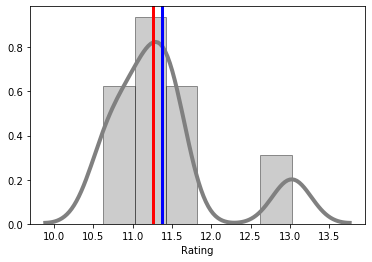

In [23]:
# Acuna, Med Upside
plot_dist('18401')

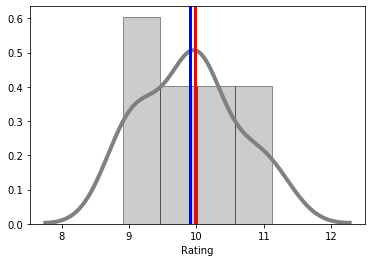

In [24]:
# Bellinger, Stable
plot_dist('15998')

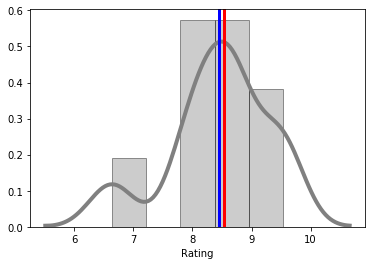

In [25]:
# Ramirez, Low Risk
plot_dist('13510')